In [2]:
import os
import sys
import keras
import random
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'C:/datasets/U_NET/train/'
TEST_PATH = 'C:/datasets/U_NET/validation/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
next(os.walk(TRAIN_PATH))[0]

'C:/datasets/U_NET/train/'

In [4]:
next(os.walk(TRAIN_PATH))[1][0:10]

['00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
 '5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590',
 '5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233',
 '5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14',
 '5b2ccfb94dedf2ec8797c0404fc324888e35ab903c41bb26f070552033ca8e6c',
 '5ba4facefc949c920d7054813a3e846b000969da2ed860148bdfd18456f59bcc',
 '5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8',
 '5bda829acd824821bc1f3f6573cf065d364653d5322f033a4af943f7a6170566',
 '5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6']

In [5]:
next(os.walk(TRAIN_PATH))[2]

[]

In [6]:
next(os.walk(TRAIN_PATH))[3]

IndexError: tuple index out of range

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
train_ids[0:5]

['00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3',
 '5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590',
 '5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233',
 '5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14']

In [9]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

Getting and resizing training images ... 


In [10]:
X_train[0][0][0:3] #Shape is  669*128*128*3

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [11]:
Y_train[0][0][0:3]

array([[False],
       [False],
       [False]])

In [12]:
my_list = ['apple', 'banana', 'grapes', 'pear']
for c, value in enumerate(my_list):
    print(c, value)

0 apple
1 banana
2 grapes
3 pear


In [13]:
len(train_ids)

20

In [14]:
img = imread('A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')
plt.imshow(img)
print(img.shape, "\n")
plt.imshow(img)

FileNotFoundError: No such file: 'A:\U_NET\train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\images\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'

In [15]:
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
print(img.shape, "\n")
plt.imshow(img)

NameError: name 'img' is not defined

In [16]:
img = imread('A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')[:,:,:IMG_CHANNELS] 
plt.imshow(img)
img.shape

FileNotFoundError: No such file: 'A:\U_NET\train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\images\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'

In [17]:
img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(img)

NameError: name 'img' is not defined

In [18]:
x = np.array([1, 2])
print(x.shape)
x = np.expand_dims(x,axis = -1)
print(x.shape)

(2,)
(2, 1)


In [19]:
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.bool)
mask_ = imread('A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/b0cbc2c553f9c4ac2191395236f776143fb3a28fb77b81d3d258a2f45361ca89.png')
mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH),mode='constant',preserve_range=True)
mask_ = np.expand_dims(mask_, axis=-1) 
mask = np.maximum(mask, mask_)
plt.imshow(mask)

FileNotFoundError: No such file: 'A:\U_NET\train\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\masks\b0cbc2c553f9c4ac2191395236f776143fb3a28fb77b81d3d258a2f45361ca89.png'

In [20]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()   #Not important in python 3
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):            #'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552' --- 0 (first element)
    path = TRAIN_PATH + id_                                                #  'A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]       # A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png (format is 256*256*3   )
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]: #'A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/'
        mask_ = imread(path + '/masks/' + mask_file)     #'A:/U_NET/train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/b0cbc2c553f9c4ac2191395236f776143fb3a28fb77b81d3d258a2f45361ca89.png'
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH),mode='constant', 
                                      preserve_range=True)
        mask_ = np.expand_dims(mask_, axis=-1)    #SHape = (128,128,1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.04it/s]

Done!


IndexError: index 20 is out of bounds for axis 0 with size 20

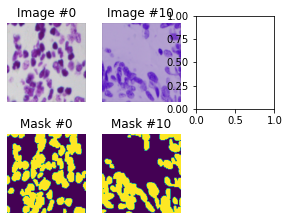

In [21]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        
        plt.subplot(y*2, x, (i*2+1)*x+j+1)        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [22]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [23]:
# Alternative IoU function
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/51553
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum((y_true,-1) + K.sum(y_pred,-1) - intersection)
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

In [24]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [25]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [26]:
# Initialize our callbacks
model_path = "A:/U_NET/nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=106, epochs=5, 
                    callbacks=[earlystop, checkpoint])

Train on 18 samples, validate on 2 samples
Epoch 1/5


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at C:\Users\Siyam\anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_6098]

Function call stack:
keras_scratch_graph


In [34]:
# Predict on training and validation data
# Note our use of mean_iou metri
model = load_model("A:/U_NET/nuclei_finder_unet_1.h5")

In [41]:


# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)  #X_train.shape[0] as images are stored in !sr dim.    #As  validation_split=0.1 #Strts from 0 to 90%

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #Start from 90% to END

#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - 1s 22ms/step


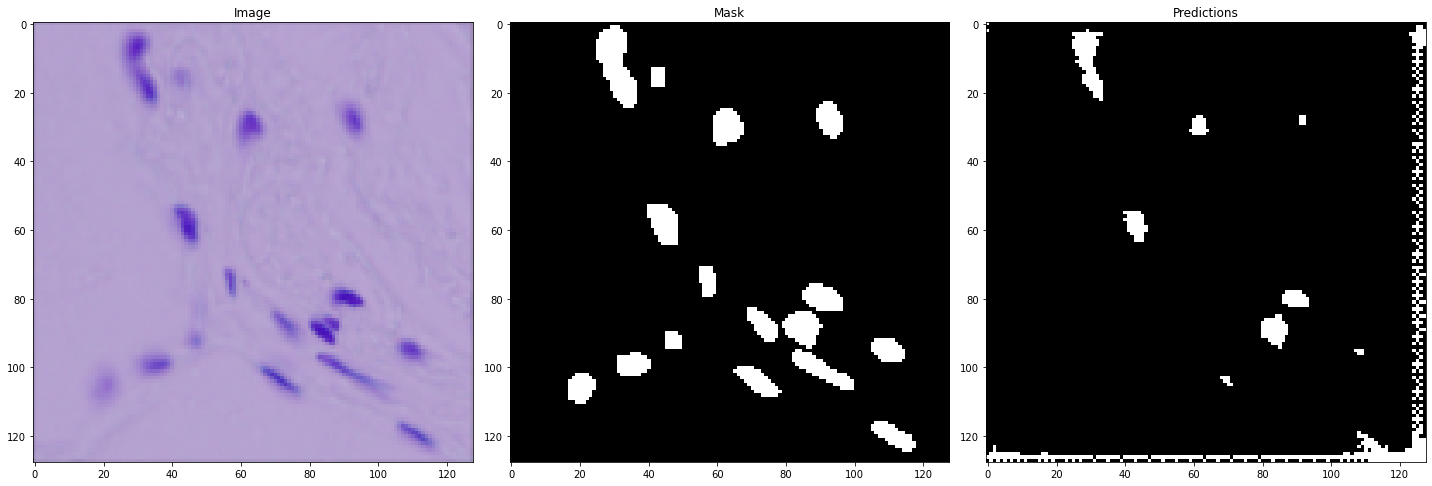

In [43]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

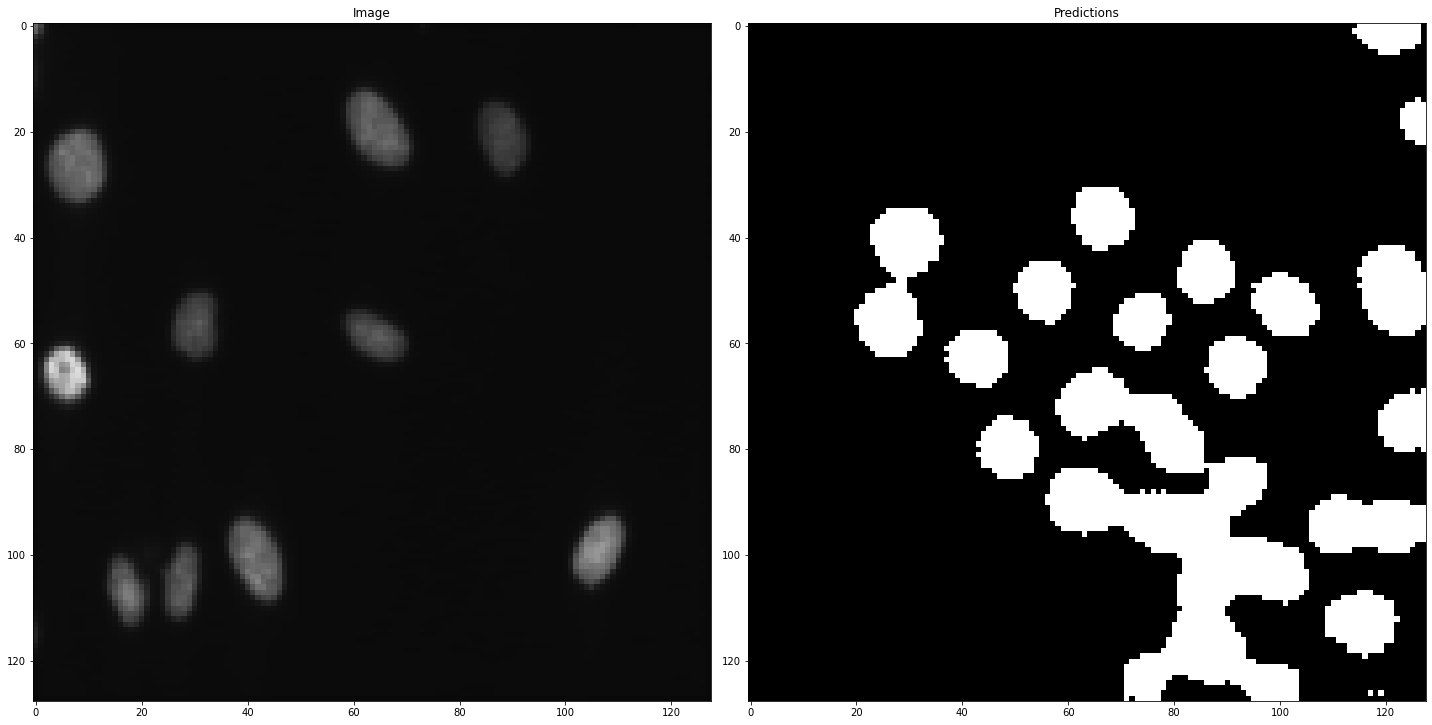

In [45]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()